In [4]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from prophet import Prophet

O Prophet é uma ferramenta desenvolvida pelo Facebook para fazer previsões em séries temporais, que são basicamente dados coletados ao longo do tempo, como os preços das ações. É famoso por ser fácil de usar e por funcionar bem mesmo com poucos dados ou com dados que possuem padrões irregulares, o que é comum no mercado de ações.

Vamos usar dados de ações da empresa Johnson & Johnson como exemplo.

Aqui, usamos um comando para baixar os dados. É como se estivéssemos pedindo à internet para nos dar os preços das ações da Johnson & Johnson desde 2020 até o final de 2023.

In [6]:
# Baixar dados dos últimos quatro anos para uma ação específica

dados = yf.download("JNJ", start = "2020-01-01", end = "2023-12-31", progress = False)
dados = dados.reset_index()
dados

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,145.869995,146.020004,145.080002,145.970001,130.099106,5777000
1,2020-01-03,143.500000,145.369995,143.000000,144.279999,128.592850,5752400
2,2020-01-06,144.000000,144.199997,142.850006,144.100006,128.432419,7731300
3,2020-01-07,144.009995,145.449997,141.380005,144.979996,129.216751,7382900
4,2020-01-08,144.869995,145.979996,143.699997,144.960007,129.198975,6605800
...,...,...,...,...,...,...,...
1001,2023-12-22,155.250000,156.529999,155.020004,155.460007,154.288544,3798500
1002,2023-12-26,155.000000,156.350006,154.850006,156.139999,154.963409,4170000
1003,2023-12-27,155.500000,156.520004,155.419998,156.350006,155.171844,5288100
1004,2023-12-28,156.000000,157.240005,155.990005,156.580002,155.400101,4377500


Agora, dividimos nossos dados em duas partes: uma para treinar nosso 'adivinho' digital, que é até julho de 2023, e outra para testar nossas previsões, que é o restante do ano.

In [7]:
# Vamos dividir os dados em treino (até o final do primeiro semestre de 2023) e teste (segundo semestre de 2023)

dados_treino = dados[dados['Date'] < '2023-07-31']
dados_teste = dados[dados['Date'] >= '2023-07-31']

In [9]:
# Preparando os dados para o FBProphet

dados_prophet_treino = dados_treino[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})
dados_prophet_treino

,ds,y
0,2020-01-02,145.970001
1,2020-01-03,144.279999
2,2020-01-06,144.100006
3,2020-01-07,144.979996
4,2020-01-08,144.960007
...,...,...
894,2023-07-24,171.080002
895,2023-07-25,172.389999
896,2023-07-26,172.720001
897,2023-07-27,173.690002


O próximo passo é preparar os dados para o nosso adivinho, o Prophet. É como se estivéssemos arrumando os dados para que ele entenda o que estamos perguntando.

Depois, criamos o modelo do Prophet. Aqui, estamos dizendo ao Prophet para considerar padrões semanais e anuais nos dados, mas não diários. E também adicionamos feriados dos EUA, já que eles podem influenciar o preço das ações.

In [10]:
# Criar e treinar o modelo

modelo = Prophet(weekly_seasonality= True,
                 yearly_seasonality= True,
                 daily_seasonality= False)

modelo.add_country_holidays(country_name='US')

modelo.fit(dados_prophet_treino)

13:02:58 - cmdstanpy - INFO - Chain [1] start processing
13:02:59 - cmdstanpy - INFO - Chain [1] done processing


Agora, a parte mágica! Pedimos ao Prophet para prever o futuro, até o final de 2023. E então, plotamos um gráfico para ver como nossa previsão se compara com os dados reais.

In [11]:
# Criar datas futuras para previsão até o final de 2023

futuro = modelo.make_future_dataframe(periods=150)
previsao = modelo.predict(futuro)

Neste gráfico, há três linhas. A azul mostra o preço real das ações até julho de 2023, a verde mostra os preços reais após essa data, e a laranja mostra o que o Prophet previu. A linha vermelha pontilhada marca onde começam as previsões.

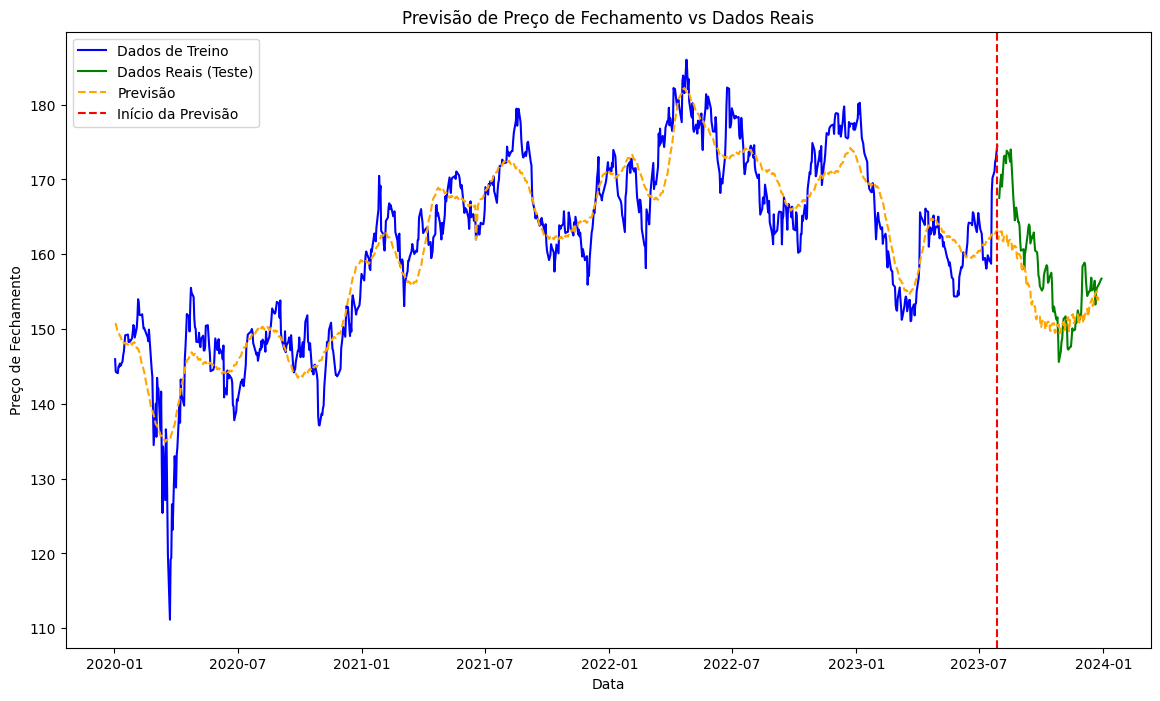

In [13]:
# Plotar os dados de treino, teste e previsões

plt.figure(figsize=(14, 8))
plt.plot(dados_treino['Date'], dados_treino['Close'], label='Dados de Treino', color='blue')
plt.plot(dados_teste['Date'], dados_teste['Close'], label='Dados Reais (Teste)', color='green')
plt.plot(previsao['ds'], previsao['yhat'], label='Previsão', color='orange', linestyle='--')

plt.axvline(dados_treino['Date'].max(), color='red', linestyle='--', label='Início da Previsão')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.title('Previsão de Preço de Fechamento vs Dados Reais')
plt.legend()
plt.show()